In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## This code tests to make sure the models give the correct likelihood values


In [ ]:
from __future__ import division


import numpy as np
import os, glob, json
import matplotlib.pyplot as plt
import pickle
import scipy.linalg as sl
import healpy as hp
import multiprocessing as mp

from enterprise.signals import parameter
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals import utils
from enterprise import constants as const

from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import sampler as ee_sampler

pklfile = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/NANOGrav_11yr_DE436.pickle'

with open(pklfile, 'rb') as f:
    psrs=pickle.load(f)
    
psr=psrs[0]

U,_ = utils.create_quantization_matrix(psr.toas)
eps = 9  # clip first and last N observing epochs
t0min = np.floor(max(U[:,eps] * psr.toas/const.day))
t0max = np.ceil(max(U[:,-eps] * psr.toas/const.day))

ramp_pta = ee_models.model_ramp([psr], upper_limit=False, bayesephem=False,
                          Tmin_bwm=t0min, Tmax_bwm=t0max)


In [ ]:
noisefile = '/home/nima/nanograv/11yr/noisefiles/noisedict.json'
with open(noisefile, 'rb') as nfile:
    setpars = json.load(nfile)
    
ramp_pta.set_default_params(setpars)


In [ ]:
print(ramp_pta.params)
print(ramp_pta.params[-1])
#print(burst_pta.params)

In [ ]:
x0=np.hstack(p.sample() for p in ramp_pta.params)
print(x0)
print(ramp_pta.params[-1])
sign_sample = ramp_pta.params[-1].sample()
print(sign_sample)

In [ ]:
for p in ramp_pta.params:
    print(str(p) + '\n')

In [ ]:

sys.path.insert(0, '/home/nima/nanograv/custom_libs/enterprise/')
sys.path.insert(0, '/home/nima/nanograv/custom_libs/enterprise_extensions/')
sys.path.insert(0, '/home/nima/nanograv/custom_libs/PTMCMCSampler/')#let's try to calculate the associated amplitude and see if the ramp_pta
#gives the same answer

pos = psr.pos

costheta = x0[2]
log10_A = x0[3]
phi = x0[4]
pol=x0[5]
t0=x0[6]

h = 10 ** log10_A
theta=np.arccos(costheta)
t0 *= const.day

apc = utils.create_gw_antenna_pattern(pos, theta, phi)
fp, fc = apc[0], apc[1]

pol = np.cos(2 * pol) * fp + np.sin(2 * pol) * fc

print(pol*h)

In [ ]:
for p in ramp_pta.params:
    print(str(p) + '\n')

In [ ]:
gamma = x0[0]
intrinsic_log10_A = x0[1]
ramp_amp = pol*h
ramp_t0 = x0[6]

print(ramp_pta.get_lnlikelihood([gamma, intrinsic_log10_A, np.log10(ramp_amp), ramp_t0]))

# Scratch Space for re-implementing the likelihood table maker
I think that this code now mostly works for creating a likelihood-table with the correct likelihoods.
It now handles the parameter ordering more robustly and guarantees that the parameters it passes into likelihood calls are in the correct order.


In [ ]:
from __future__ import division

import numpy as np
import os, glob, json
import matplotlib.pyplot as plt
import pickle
import scipy.linalg as sl
import healpy as hp
import multiprocessing as mp

from enterprise.signals import parameter
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals import utils
from enterprise import constants as const

from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import sampler as ee_sampler


from la_forge.core import Core, load_Core
from la_forge import rednoise
from la_forge.diagnostics import plot_chains

pklfile = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/NANOGrav_11yr_DE436.pickle'
with open(pklfile, 'rb') as f:
    psrs=pickle.load(f)

noisefile = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/noisefiles/noisedict.json'
with open(noisefile, 'rb') as f:
    setpars = json.load(f)
    
psr = psrs[0]
        

################### ==========================
### OG Fnc Body ### ==========================
################### ==========================



################
### SPACING ####
################

### Start by defining the spacing for each of these parameters

tmin = psr.toas.min() / const.day
tmax = psr.toas.max() / const.day

U,_ = utils.create_quantization_matrix(psr.toas)
eps = 9  # clip first and last N observing epochs
t0min = np.floor(max(U[:,eps] * psr.toas/const.day))
t0max = np.ceil(max(U[:,-eps] * psr.toas/const.day))

Ts = np.linspace(t0min, t0max, num=100, endpoint=True)
time_name = 'ramp_t0'
time_spacing = '{},{},100'.format(t0min, t0max)

signs = np.linspace(-1,1,2)
sign_spacing = '-1,1,2'
sign_name = 'sign'


log10_burst_amplitudes = np.linspace(-17, -12, 50, endpoint=True) #grid points for the burst strain
burst_amp_spacing = '-17,-12,50'
burst_amp_name = 'ramp_log10_A'


log10_rn_amps = np.linspace(-20, -12, 80, endpoint=True) #grid points for the pulsar red noise
rn_amp_spacing = '-17,-12,50'
rn_amp_name = psr.name + '_red_noise_log10_A'


gammas = np.linspace(0, 7, 70, endpoint=True) #grid points for gamma'
gamma_spacing ='0,7,70'
gamma_name=psr.name + '_red_noise_gamma'

# Now we collect all of these in a dictionary for the pta so it can sample in whichever order it turns out to be
# This is because I'm worried that the order of the params is off, and we're sampling the wrong values for the params
# The dictionary will look something like:

# param_spacing_dict[par_name] = (actual_array, spacing_text)

param_spacing_dict = {}

param_spacing_dict[time_name] = (Ts, time_spacing) 
param_spacing_dict[sign_name] = (signs, sign_spacing)
param_spacing_dict[burst_amp_name] = (log10_burst_amplitudes, burst_amp_spacing)
param_spacing_dict[rn_amp_name] = (log10_rn_amps, rn_amp_spacing)
param_spacing_dict[gamma_name] = (gammas, gamma_spacing) 




outdir = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v3/'
if not os.path.exists(outdir + psr.name):
    os.mkdir(outdir + psr.name)



##################
#####   PTA   ####
##################

### Define the PTA 


pta = ee_models.model_ramp([psr],
                      upper_limit=False, bayesephem=False,
                      Tmin_bwm=t0min, Tmax_bwm=t0max)

pta.set_default_params(setpars)


outfile = outdir + psr.name + '/pars.txt'
with open(outfile, 'w') as f:
    for pname in pta.param_names:
        f.write(pname+';'+param_spacing_dict[pname][1]+'\n')


In [ ]:
print(pta.param_names)
print(param_spacing_dict['sign'])


In [ ]:
# Now that the parameters are defined, we need to build an x_0 in the right order to pass into the pta
# to evaluate the likelihood

idxs = []

for param in pta.param_names:
    idxs.append(len(param_spacing_dict[param][0]))
likelihoods = []
print(idxs)

for i4 in range(idxs[4]):
    for i3 in range(idxs[3]):
        for i2 in range(idxs[2]):
            for i1 in range(idxs[1]):
                for i0 in range(idxs[0]):
                    xs = []
                    xs.append(param_spacing_dict[pta.param_names[0]][0][i0])
                    xs.append(param_spacing_dict[pta.param_names[1]][0][i1])
                    xs.append(param_spacing_dict[pta.param_names[2]][0][i2])
                    xs.append(param_spacing_dict[pta.param_names[3]][0][i3])
                    xs.append(param_spacing_dict[pta.param_names[4]][0][i4])
                    
                    likelihoods.append(pta._lnlikelihood.__call__(xs))
    
                                 
                    



In [ ]:
from sys import getsizeof
print(getsizeof(likelihoods)/(1024)/1024/1024)

In [ ]:
type(pta._lnlikelihood)

In [ ]:
np.savetxt('/home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v3/B1855+09/B1855+09_lookup.txt', likelihoods)

# # Below are cells for testing binary search

In [ ]:
from __future__ import division

import numpy as np
import os, sys

from enterprise.signals import utils

def find_closest(target, data):
    closest = 0
    for idx in range(len(data)):
        if abs(target - data[idx]) < abs(target - data[closest]):
            closest = idx

    return idx

def find_two_closest(target, data):
    closest = 0
    next_closest = 1
    
    for idx in range(len(data)):
        if abs(target - data[idx]) < abs(target - data[closest]):
            closest = idx
        elif abs(target - data[idx]) < abs(target - data[next_closest]):
            next_closest = idx
        
    return closest, next_closest

In [ ]:
params_dict = {}

log10_burst_amplitudes = np.linspace(-20, -12, 80, endpoint=True) #grid points for the burst strain
log10_rn_amps = np.linspace(-20, -12, 80, endpoint=True) #grid points for the pulsar red noise

Ngammas = 70
gmin = 0
gmax = 7
gammas = np.linspace(gmin, gmax, Ngammas, endpoint=True) #grid points for gamma


U,_ = utils.create_quantization_matrix(psr.toas)
eps = 9  # clip first and last N observing epochs
t0min = np.floor(max(U[:,eps] * psr.toas/const.day))
t0max = np.ceil(max(U[:,-eps] * psr.toas/const.day))

Ts = np.linspace(t0min, t0max, num=100, endpoint=True)

params_dict["J1909-3744_red_noise_gamma"] = gammas
params_dict["J1909-3744_red_noise_log10_A"] = log10_rn_amps
params_dict["ramp_log10_A"] = log10_burst_amplitudes
params_dict["ramp_t0"] = Ts

x0=np.hstack(p.sample() for p in ramp_pta.params)

gamma = x0[0]
log10_rn = x0[1]
log10_ramp = x0[2]
ramp_t0 = x0[3]

print(x0)

In [ ]:
for each in psrs:
    if each.name == "J1909-3744":
        psr = each.name
        
params_dict = {}

log10_burst_amplitudes = np.linspace(-20, -12, 80, endpoint=True) #grid points for the burst strain
log10_rn_amps = np.linspace(-20, -12, 80, endpoint=True) #grid points for the pulsar red noise

Ngammas = 70
gmin = 0
gmax = 7
gammas = np.linspace(gmin, gmax, Ngammas, endpoint=True) #grid points for gamma


U,_ = utils.create_quantization_matrix(psr.toas)
eps = 9  # clip first and last N observing epochs
t0min = np.floor(max(U[:,eps] * psr.toas/const.day))
t0max = np.ceil(max(U[:,-eps] * psr.toas/const.day))

Ts = np.linspace(t0min, t0max, num=100, endpoint=True)

params_dict["J1909-3744_red_noise_gamma"] = gammas
params_dict["J1909-3744_red_noise_log10_A"] = log10_rn_amps
params_dict["ramp_log10_A"] = log10_burst_amplitudes
params_dict["ramp_t0"] = Ts

## For this search, if we know which indices are closest, we can just
## go directly to the right line

# Find the indices of the closest and next closest numbers to the ne in sample


In [ ]:
x0=np.hstack(p.sample() for p in ramp_pta.params)

gamma = x0[0]
log10_rn = x0[1]
log10_ramp = x0[2]
ramp_t0 = x0[3]

print(x0)

In [ ]:
gamma_closest, gamma_second_closest = find_two_closest(gamma, gammas)
log10rn_closest, log10rn_second_closest = find_two_closest(log10_rn, log10_rn_amps)
log10ramp_closest, log10ramp_second_closest = find_two_closest(log10_ramp, log10_burst_amplitudes)
t0_closest, t0_second_closest = find_two_closest(ramp_t0, Ts)

print(gamma_closest, gamma_second_closest)
print(gamma, gammas[60], gammas[61])

In [ ]:
closest_idx = 

## This code uses lookup tables to run a factorized likelihood BWM Ramp estimation

In [1]:
from __future__ import division


import sys

import numpy as np
import os, glob, json
import matplotlib.pyplot as plt
import pickle
import scipy.linalg as sl
import healpy as hp
import multiprocessing as mp
import time

from enterprise.signals import parameter
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals import utils
from enterprise import constants as const

from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import sampler as ee_sampler
from enterprise.signals.signal_base import LookupLikelihood
from enterprise.signals.signal_base import LogLikelihood

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

pklfile = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/NANOGrav_11yr_DE436.pickle'
with open(pklfile, 'rb') as f:
    psrs=pickle.load(f)
    
for each in psrs:
    if each.name == "B1855+09":
        psr = each

noisefile = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/noisefiles/noisedict.json'
lookupdir = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v4/'
U,_ = utils.create_quantization_matrix(psr.toas)
eps = 9  # clip first and last N observing epochs
t0min = np.floor(max(U[:,eps] * psr.toas/const.day))
t0max = np.ceil(max(U[:,-eps] * psr.toas/const.day))

pta = ee_models.model_ramp([psr], LookupLikelihood, lookupdir=lookupdir, upper_limit=False, bayesephem=False,
                          Tmin_bwm=t0min, Tmax_bwm=t0max)



outdir = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/sgl_psr_run/ramp_factorized_v4/'
np.savetxt(outdir+'pars.txt',list(map(str, pta.param_names)), fmt='%s')
np.savetxt(outdir+'priors.txt',list(map(lambda x: str(x.__repr__()), pta.params)), fmt='%s')


INFO: astropy: Running get_iers_up_to_date() to update IERS B table


INFO: Running get_iers_up_to_date() to update IERS B table [pint.erfautils]
No noise dictionary provided!...


In [2]:
noisefile = '/home/nima/nanograv/11yr/noisefiles/noisedict.json'
with open(noisefile, 'rb') as nfile:
    setpars = json.load(nfile)

pta.set_default_params(setpars)


INFO: enterprise.signals.signal_base: Setting B1855+09_430_ASP_efac to 1.15373
INFO: enterprise.signals.signal_base: Setting B1855+09_430_PUPPI_efac to 1.12092
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_ASP_efac to 1.08632
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_PUPPI_efac to 1.37768
INFO: enterprise.signals.signal_base: Setting B1855+09_430_ASP_log10_equad to -8.87356
INFO: enterprise.signals.signal_base: Setting B1855+09_430_PUPPI_log10_equad to -6.17217
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_ASP_log10_equad to -6.50338
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_PUPPI_log10_equad to -6.53848
INFO: enterprise.signals.signal_base: Setting B1855+09_430_ASP_log10_ecorr to -7.31698
INFO: enterprise.signals.signal_base: Setting B1855+09_430_PUPPI_log10_ecorr to -6.31615
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_ASP_log10_ecorr to -6.09398
INFO: enterprise.signals.signal_base: Setting B185

In [3]:
x0 = np.hstack(p.sample() for p in pta.params)
print(pta.params)

[B1855+09_red_noise_gamma:Uniform(pmin=0, pmax=7), B1855+09_red_noise_log10_A:Uniform(pmin=-17, pmax=-12), ramp_log10_A:Uniform(pmin=-17, pmax=-12), ramp_t0:Uniform(pmin=53448.0, pmax=57265.0), sign:Uniform(pmin=-1, pmax=1)]


/home/nima/anaconda3/envs/enterprise/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [4]:
pta.get_lnlikelihood(x0)
print(type(pta._lnlikelihood))
print(pta.get_lnlikelihood(x0))

Looking for parfile in: /home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v4/B1855+09/pars.txt
I think you want a lookuplikelihood in signal_base._lnlikelihood
<class 'enterprise.signals.signal_base.LookupLikelihood'>
65277.338365983334


In [5]:
ndim = len(x0)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.1**2)

np.savetxt(outdir+"pars.txt",list(map(str, pta.param_names)), fmt='%s')
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov,  outDir=outdir, resume=False)

In [6]:
jp = ee_sampler.JumpProposal(pta)
sampler.addProposalToCycle(jp.draw_from_prior, 30)

sampler.sample(x0, int(3e5), SCAMweight=30, AMweight=50, DEweight=0)

/home/nima/anaconda3/envs/enterprise/lib/python3.7/site-packages/enterprise/signals/parameter.py:64: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 3.33 percent in 7.822983 s Acceptance rate = 0.426625Adding DE jump with weight 0
Finished 99.67 percent in 237.471294 s Acceptance rate = 0.349482
Run Complete


In [ ]:
pta.get_lnlikelihood(x0)

## Postprocessing the Above


In [7]:
from la_forge.core import Core
from la_forge.diagnostics import plot_chains

In [8]:
chaindir_factorized = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/sgl_psr_run/ramp_factorized_v4/'
chaindir_noramp = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/sgl_psr_run/ramp_pta_no_ramp/'
#chaindir_standard_bwm = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/sgl_psr_run/burst_pta_paul_sgl/'
chaindir_standard_ramp = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/sgl_psr_run/ramp_pta_jerry_sgl/'
core_factorized=Core(label="B1855 BWM Factorized", chaindir=chaindir_factorized, burn=0)
core_noramp = Core(label="B1855 Ram PTA, A=0", chaindir=chaindir_noramp, burn=0)
#core_standard_bwm=Core(label="B1855 BWM Standard BWM Run", chaindir = chaindir_standard_bwm, burn=0)
core_standard_ramp=Core(label="B1855 Ramp Standard BWM Run", chaindir = chaindir_standard_ramp, burn=0)

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.
Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.
Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


/home/nima/anaconda3/envs/enterprise/lib/python3.7/site-packages/la_forge/core.py:109: UserWarning: loadtxt: Empty input file: "/home/nima/nanograv/11yr_burst_factorizedlikelihood/sgl_psr_run/ramp_pta_jerry_sgl/draw_from_bwm_prior_jump.txt"
  self.jumps[ky] = np.loadtxt(path, dtype=dtype)


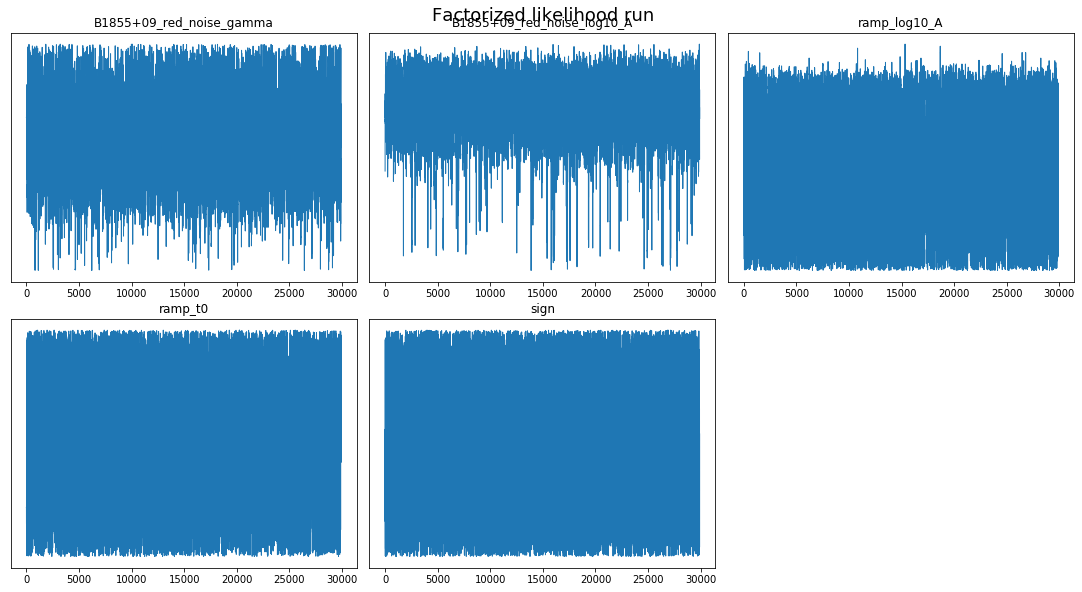

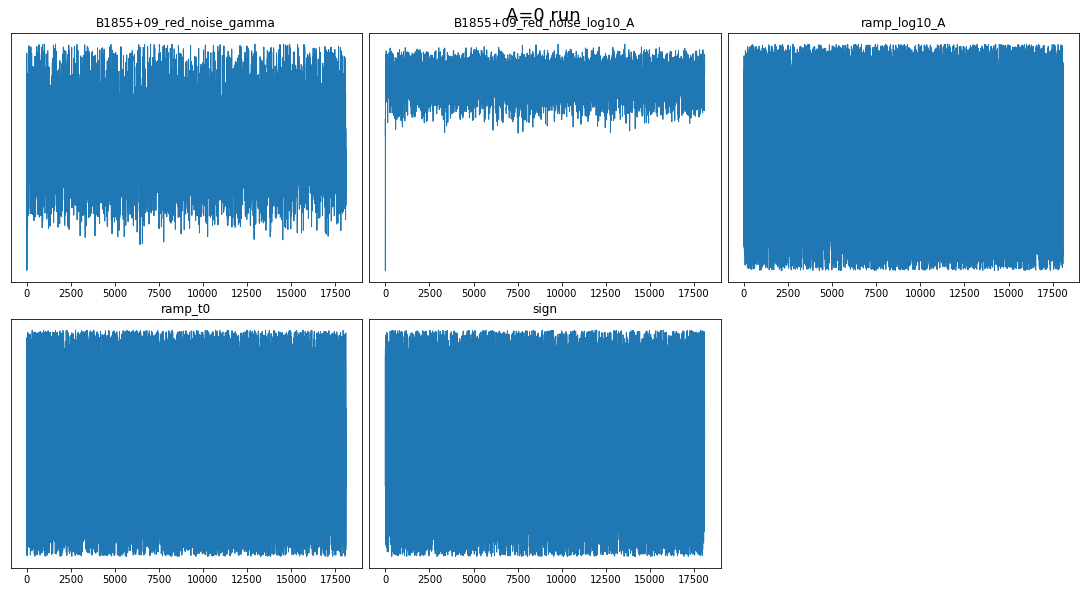

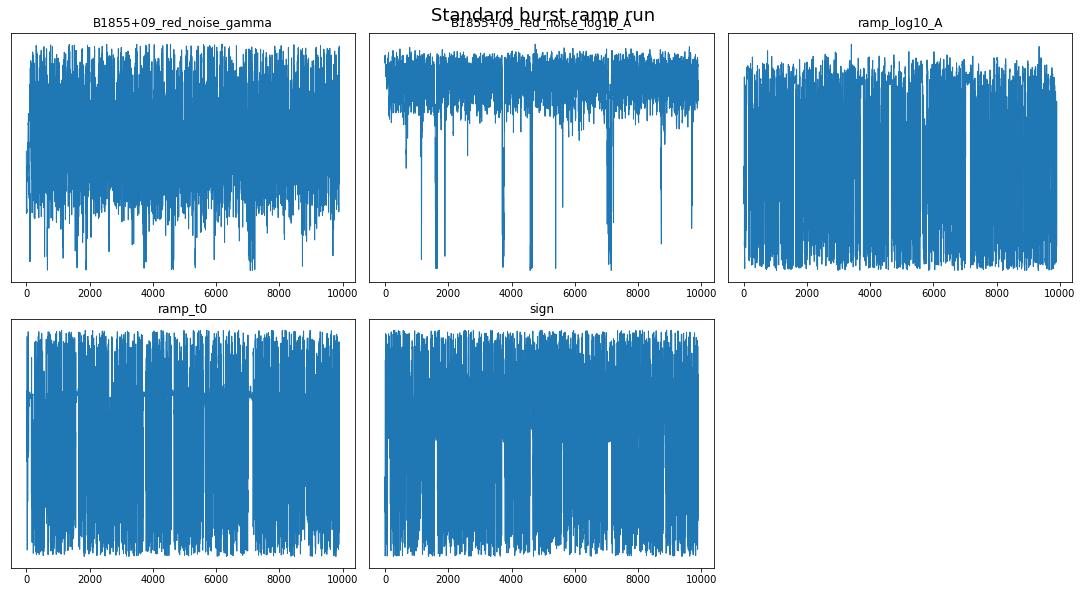

In [9]:
plot_chains(core_factorized, hist=False, suptitle= "Factorized likelihood run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])
plot_chains(core_noramp, hist=False, suptitle= "A=0 run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])
#plot_chains(core_standard_bwm, hist=False, suptitle= "Standard burst bwm run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])
plot_chains(core_standard_ramp, hist=False, suptitle= "Standard burst ramp run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])

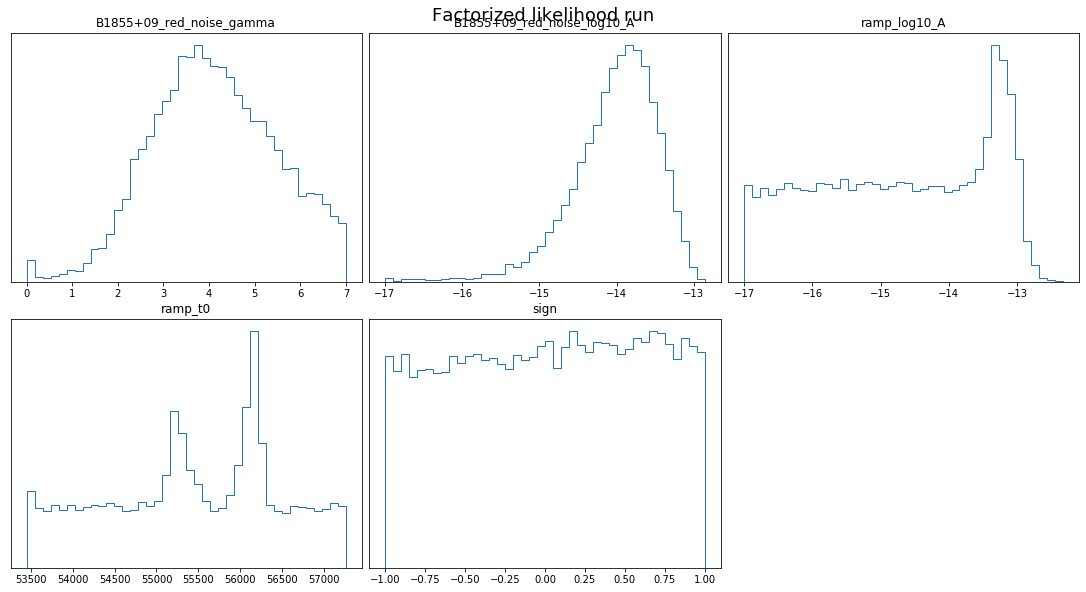

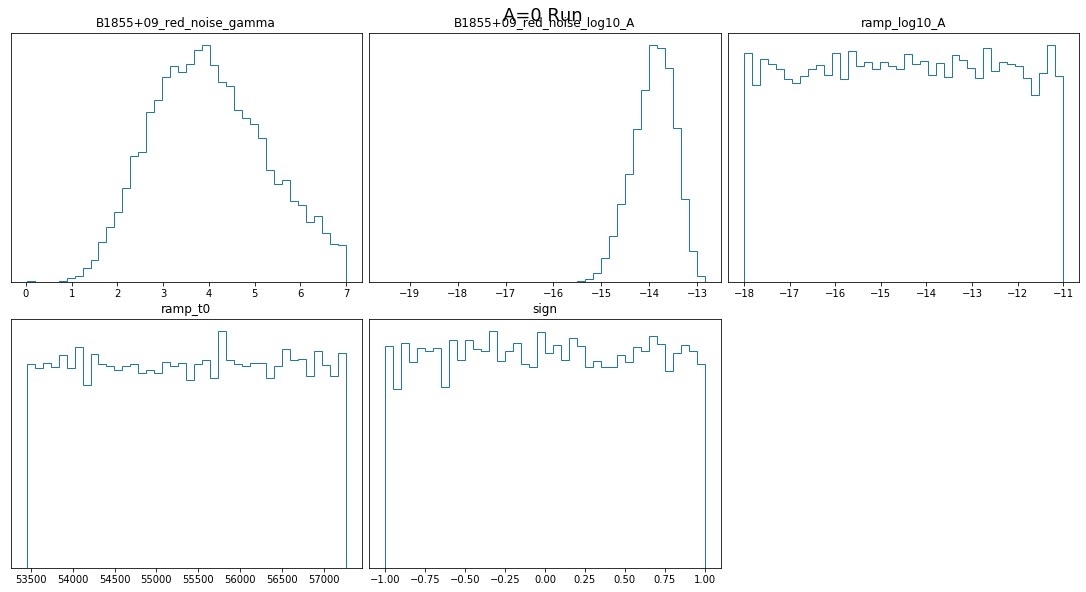

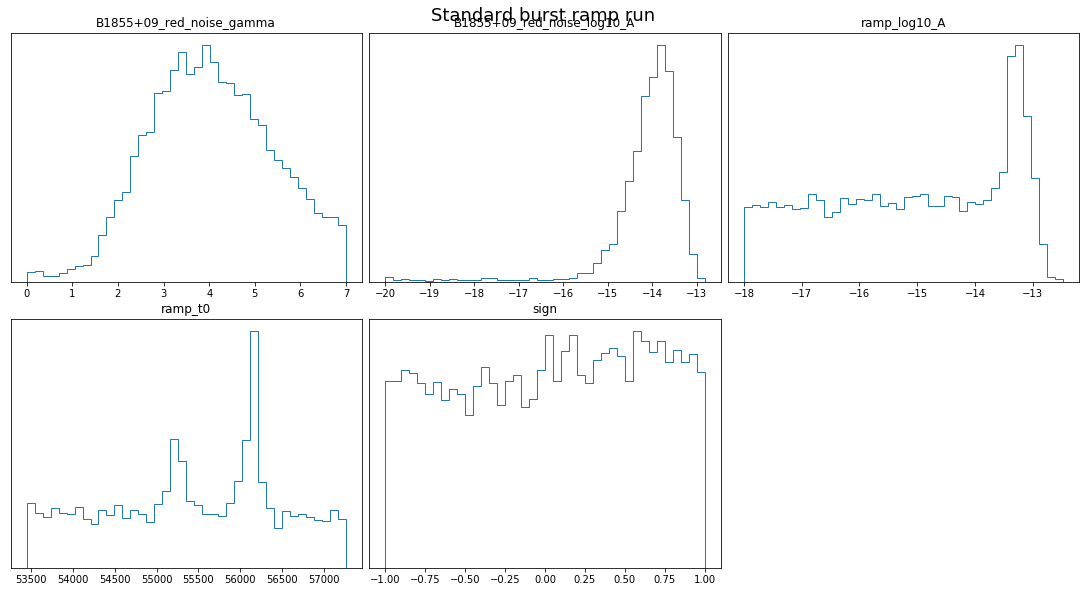

In [10]:
plot_chains(core_factorized, hist=True, suptitle= "Factorized likelihood run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])
plot_chains(core_noramp, hist=True, suptitle= "A=0 Run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])

#plot_chains(core_standard_bwm, hist=True, suptitle= "Standard burst bwm run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])
plot_chains(core_standard_ramp, hist=True, suptitle= "Standard burst ramp run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])

# Miscellaneous Scratch Work (comparing different runs in depth mostly)

In [ ]:
indiv_log10_As = core_factorized.get_param("B1855+09_red_noise_log10_A")
signs = core_factorized.get_param("sign")

positive_idxs = []
negative_idxs = []
for idx in range(len(signs)):
    if signs[idx] > 0:
        positive_idxs.append(idx)
    else:
        negative_idxs.append(idx)

positive_log10_As = []
negative_log10_As = []
for idx in positive_idxs:
    positive_log10_As.append(indiv_log10_As[idx])

for idx in negative_idxs:
    negative_log10_As.append(indiv_log10_As[idx])

plt.hist(positive_log10_As, bins=30, fill=False)


In [ ]:
plt.hist(negative_log10_As, bins=30, fill=False)

In [ ]:
# We notice in the above two plots of the standard runs, the ramp_log10_A is pretty much preferring -14 to -13.
# Let's excise the elements of the chains where this happens and see if the lookup table agrees

log10_As_chain = core_standard_ramp.get_param("ramp_log10_A")
idxs = []
for link_idx in range(len(log10_As_chain)):
    if log10_As_chain[link_idx] > -14 and log10_As_chain[link_idx] < -13:
        idxs.append(link_idx)

pref_As_chain = []
for link_idx in range(len(core_standard_ramp.chain)):
    if link_idx in idxs:
        pref_As_chain.append(core_standard_ramp.chain[link_idx])
    


In [ ]:
## lnprior is now actually lnlike, at index -3, thanks to the addition of the temperature in the chain 
## TODO: Have to fix this because it's actually causing unwanted side effects in la_forge

xs = np.array(pref_As_chain)[:, 0:5]
lnlikes = np.array(pref_As_chain)[:, -3]
#print(xs)
#print(lnlikes)

print(max(lnlikes))
print(max(likelihoods))

#These give the same-ish number.. this looks like it works, but I think it's the same as before!

In [ ]:
# Let's make some corner plots of A and gamma
import corner

Arns = core_standard_ramp.get_param("B1855+09_red_noise_log10_A")
gammas = core_standard_ramp.get_param("B1855+09_red_noise_gamma")

data=np.vstack([Arns, gammas]).T
print(data)
corner.corner(data)

In [ ]:
import copy

factorized_signs = core_factorized.get_param("sign")
idxs = []
for i in range(len(factorized_signs)):
    if factorized_signs[i] < 0:
        idxs.append(i)
        
        
factorized_t0s = core_factorized.get_param("ramp_t0")

negative_signed_t0s = []
positive_signed_t0s = copy.deepcopy(factorized_t0s)

print(len(positive_signed_t0s), len(idxs))
positive_signed_t0s = np.delete(positive_signed_t0s, idxs)

      
for idx in idxs:
    negative_signed_t0s.append(factorized_t0s[idx])
    
print(len(negative_signed_t0s) + len(positive_signed_t0s))
print(len(factorized_t0s))



In [ ]:
plt.hist(negative_signed_t0s, bins=30)
plt.title("burst epochs with negative sign")

In [ ]:
plt.hist(positive_signed_t0s, bins=30)
plt.title("burst epochs with positive sign")

# Actual random tomfoolery

In [ ]:
psrs = []
noise_path = '/home/nima/nanograv/15yr_prelim1/noisefiles/noisedict.json'
pkl_path = '/home/nima/nanograv/15yr_prelim1/nano15yr_prelim1_DE438_BIPM2018_45psrs.pkl'

with open(pkl_path, 'rb') as f:
    psrs=pickle.load(f)

#Load in noise parameters
with open(noise_path, 'r') as f:
    noise_params = json.load(f)
    
pta=ee_models.model_general(psrs, common_psd='powerlaw', red_psd='powerlaw', common_components=5, red_components=30)


In [ ]:
pta.set_default_params(noise_params)

In [ ]:
print(pta._commonsignals)
print(pta.param_names)

In [ ]:
print(pta.signals['B1855+09_gw'].get_basis.modes)